```
Copyright (c) Gradient Institute. All rights reserved.
Licensed under the Apache 2.0 License.
```


This notebook demonstrates the effect of feature dimensionality on linear models.

Hahn, P.R., Carvalho, C.M., Puelz, D., He, J., 2018. Regularization and Confounding in Linear Regression for Treatment Effect Estimation. Bayesian Anal. 13. https://doi.org/10.1214/16-BA1044


In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.kernel_approximation import RBFSampler, SkewedChi2Sampler
from sklearn.metrics import mean_squared_error

from twostageridge import TwoStageRidge, make_combined_stage_scorer, ridge_weights

# Generate the data

In [26]:
np.random.seed(42)

min_proj = 20
max_proj = 300
dim_steps = 7
projected_dims = np.linspace(min_proj, max_proj, dim_steps).round().astype(int)
N = 500
rbf_gamma = 1.
non_zero_proportion = 0.5


# Latent confounders - X
D = 5
mu_x = np.zeros(D)
A = np.random.randn(D, D)
cov_x = A @ A.T / D


# Treatment - Z
sig_eps = 0.5


# Target - Y
alpha = 1.0
sig_nu = 1.0


# Number of random dataset draws to create error bars
S = 30


# Real generative weights
gamma_max = np.random.randn(max_proj) * np.random.binomial(n=1, p=non_zero_proportion, size=max_proj)
beta_max = np.random.randn(max_proj) * np.random.binomial(n=1, p=non_zero_proportion, size=max_proj)


# Generation function
def generate_data(proj_D):
    
    gamma = gamma_max[:proj_D] / np.sqrt(proj_D * non_zero_proportion)
    beta = beta_max[:proj_D] / np.sqrt(proj_D * non_zero_proportion)
    
    # Generate the latent covariates, and then a smooth non-linear function of these
    Xo = np.random.multivariate_normal(mean=mu_x, cov=cov_x, size=N)
    X = RBFSampler(n_components=proj_D, gamma=rbf_gamma).fit_transform(Xo)
    
    # Generate data according to the causal relationships X->Z, X->Y, Z->Y
    Z = X @ gamma + sig_eps * np.random.randn(N)
    Y = alpha * Z + X @ beta + sig_nu * np.random.randn(N)

    W = np.hstack((Z[:, np.newaxis], X))
    
    return W, Y

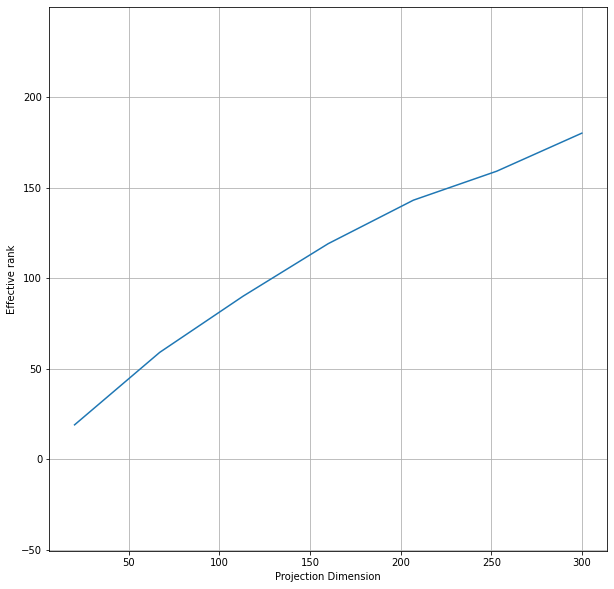

In [27]:
# Effective rank
erank = np.zeros_like(projected_dims)
for i, d in enumerate(projected_dims):
    W, _ = generate_data(d)
    _, s, _ = np.linalg.svd(W)
    norm_s = np.abs(s).sum()
    p = s / norm_s
    erank[i] = np.exp(-(p * np.log(p)).sum())

plt.figure(figsize=(10, 10))
plt.plot(projected_dims, erank)
plt.grid()
plt.axis("equal")
plt.xlabel("Projection Dimension")
plt.ylabel("Effective rank")
plt.show()

# Generate bias comparison results

In [28]:
# Naive Ridge model
from sklearn.base import BaseEstimator, RegressorMixin

class NaiveRidge(BaseEstimator, RegressorMixin):
    
    def __init__(self, alpha=1., treatment_index=0):
        self.alpha = alpha
        self.treatment_index = treatment_index
        
    def fit(self, W, y):
        N = len(W)
        Wint = np.hstack((W, np.ones((N, 1))))
        reg = np.ones(Wint.shape[1]) * self.alpha
        reg[self.treatment_index] = 0.
        self.coef_ = ridge_weights(Wint, y, gamma=reg)
        self.alpha_ = self.coef_[self.treatment_index]
        return self
    
    def predict(self, W):
        N = len(W)
        Wint = np.hstack((W, np.ones((N, 1))))
        y_hat = np.squeeze(Wint @ self.coef_)
        return y_hat
    
    def get_params(self, deep):
        return {
            'alpha': self.alpha,
            'treatment_index': self.treatment_index
        }

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

In [29]:
ridge_coefs = [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

# Two stage with grid-search
ts = GridSearchCV(
    TwoStageRidge(treatment_index=0),
    param_grid={"regulariser1": ridge_coefs, "regulariser2": ridge_coefs},
    cv=5
)

# naive ridge grid search
ridge_naive = GridSearchCV(
    NaiveRidge(treatment_index=0),
    param_grid={"alpha": ridge_coefs},
    cv=5
)

In [30]:

models = {
    "ols": LinearRegression(),
    "lasso": LassoCV(n_alphas=20, max_iter=20000, cv=5),
    "ridge": RidgeCV(ridge_coefs, cv=5),
    "t-s": ts,
    "ridge-naive": ridge_naive
}

n_D = len(projected_dims)
results_dict = {"dimensionality": projected_dims}
results_dict.update({k + "_err": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_err_std": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias": np.zeros(n_D) for k in models.keys()})
results_dict.update({k + "_bias_std": np.zeros(n_D) for k in models.keys()})
results = pd.DataFrame(results_dict).set_index("dimensionality")

In [31]:
for proj_D in projected_dims:
    
    err = {k: np.zeros(S) for k in models.keys()}
    bias = {k: np.zeros(S) for k in models.keys()}
    
    # Sample random datasets
    for s in range(S):

        # Generate the data and split into train and test
        W, Y = generate_data(proj_D)
        W_train, W_test, Y_train, Y_test = train_test_split(W, Y, train_size=0.9)
        
        for name, model in models.items():

            # Fit the model and get the ATE (alpha)
            model.fit(W_train, Y_train)
            alpha_hat = model.best_estimator_.alpha_ if name in ["t-s", "ridge-naive"] else model.coef_[0]
            bias[name][s] = (alpha - alpha_hat)**2

            # Score on held-out data
            err[name][s] = mean_squared_error(Y_test, model.predict(W_test))

        print('.', end='')
        
    for name in models.keys():
        results.loc[proj_D, name + "_err"] = err[name].mean()
        results.loc[proj_D, name + "_err_std"] = err[name].std()
        results.loc[proj_D, name + "_bias"] = bias[name].mean()
        results.loc[proj_D, name + "_bias_std"] = bias[name].std()
        
    print()
    
results

..............................
..............................
..............................
..............................
..............................
..............................
..............................


,ols_err,lasso_err,ridge_err,t-s_err,ridge-naive_err,ols_err_std,lasso_err_std,ridge_err_std,t-s_err_std,ridge-naive_err_std,ols_bias,lasso_bias,ridge_bias,t-s_bias,ridge-naive_bias,ols_bias_std,lasso_bias_std,ridge_bias_std,t-s_bias_std,ridge-naive_bias_std
dimensionality,,,,,,,,,,,,,,,,,,,,
20,0.989501,0.966041,0.974428,0.966320,0.966994,0.211980,0.202972,0.208573,0.204573,0.205421,0.008090,0.007090,0.010090,0.008003,0.006958,0.010733,0.014141,0.015404,0.010346,0.009365
67,1.178702,1.027429,1.030723,1.031189,1.029495,0.212969,0.226748,0.218174,0.220653,0.222014,0.011198,0.013208,0.015252,0.008414,0.008028,0.017171,0.019672,0.019144,0.012314,0.011570
113,1.435472,1.039709,1.054058,1.037912,1.039233,0.256100,0.192513,0.193052,0.196430,0.200091,0.012746,0.010079,0.012564,0.007277,0.006770,0.019820,0.017156,0.017470,0.010215,0.010438
160,1.680960,1.054598,1.069983,1.056995,1.055247,0.347618,0.174798,0.183181,0.183441,0.182960,0.015869,0.009357,0.012724,0.009868,0.007817,0.020481,0.015046,0.018052,0.011068,0.009345
207,2.966046,0.998949,1.009094,1.005783,1.005403,1.190690,0.209954,0.203411,0.207964,0.207319,0.023425,0.009994,0.017549,0.007402,0.007306,0.028510,0.010729,0.016057,0.009218,0.008907
253,4.627580,1.041540,1.049172,1.039348,1.041080,1.901023,0.206845,0.205262,0.208487,0.209469,0.022847,0.015004,0.020541,0.011782,0.011420,0.030333,0.015818,0.019640,0.018853,0.015290
300,14.068620,1.022663,1.026992,1.018617,1.018521,10.611226,0.218794,0.222299,0.216337,0.217370,0.016145,0.009660,0.016063,0.006207,0.006599,0.022417,0.012964,0.017095,0.009188,0.009567


# Plot

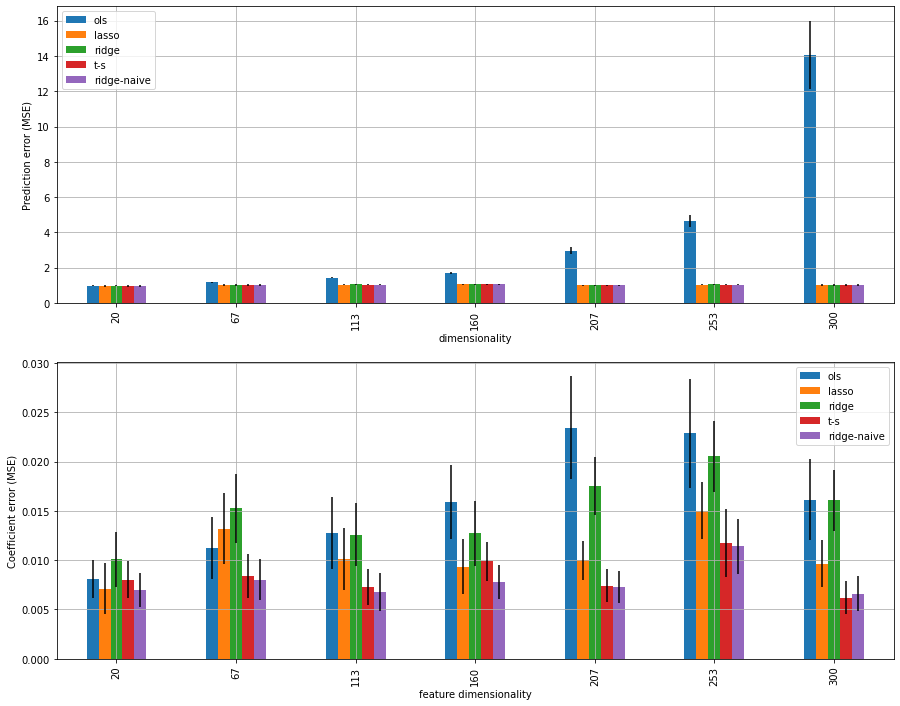

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
pred_errors = [name + "_err" for name in models.keys()]
model_errstd = results[[name + "_err_std" for name in models.keys()]] / np.sqrt(S)
model_errstd.columns = pred_errors
results[pred_errors].plot(kind='bar', yerr=model_errstd, ax=ax1)
    
ax1.set_ylabel("Prediction error (MSE)")
ax1.grid()
ax1.legend(models.keys())

model_biases = [name + "_bias" for name in models.keys()]
model_bstds = results[[name + "_bias_std" for name in models.keys()]] / np.sqrt(S)
model_bstds.columns = model_biases
results[model_biases].plot(kind='bar', yerr=model_bstds, ax=ax2)
    
ax2.set_ylabel("Coefficient error (MSE)")
ax2.grid()
ax2.legend(models.keys())
ax2.set_xlabel("feature dimensionality")
plt.show()